Giai đoạn 1: Hiểu về bối cảnh kinh doanh

Mục tiêu：

Dự án này khám phá cơ chế dự đoán churn (khách hàng rời bỏ) sử dụng dữ liệu hành vi có cấu trúc. Tuân theo từng giai đoạn của phương pháp CRISP-DM, dự án xây dựng một cách có hệ thống mô hình dự đoán churn khách hàng.

Câu hỏi chính：
- Những đặc trưng hành vi nào chỉ ra rõ nhất việc khách hàng rời bỏ?
- Làm thế nào để tận dụng dữ liệu hành vi có cấu trúc nhằm cải thiện hiệu suất dự đoán churn?
- Mức độ chính xác dự đoán nào có thể đạt được khi chỉ sử dụng dữ liệu có cấu trúc?

Tiêu chí thành công：
Dự án này sẽ xây dựng mô hình phân loại đạt F1 Score ≥ 0.60.

Giai đoạn 2: Hiểu về dữ liệu

2.1: Thu thập dữ liệu ban đầu
Chúng ta sẽ sử dụng bộ dữ liệu churn khách hàng bao gồm dữ liệu hành vi có cấu trúc, lấy từ bộ dữ liệu công khai trên Kaggle.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
import pandas as pd

# Tải bộ dữ liệu Telco Customer Churn gốc được công bố bởi BlastChar
df = pd.read_csv('../data/Customer_Churn.csv', encoding='utf-8')
# Hiển thị danh sách tên cột
print("Tên các cột:", df.columns.tolist())

# Xem trước vài dòng đầu tiên của bộ dữ liệu
df.head()


Tên các cột: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
1,6834-NXDCA,Female,0,No,No,13,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.90,300.8,Yes
2,6158-DWPZT,Male,0,Yes,No,9,No,No phone service,DSL,No,...,No,No,No,No,One year,No,Bank transfer (automatic),24.10,259.8,Yes
3,2346-DJQTB,Female,0,No,No,35,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,24.15,812.5,No
4,5351-QESIO,Male,0,No,Yes,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,24.20,24.2,No


In [3]:
print("Số dòng và cột: ")
df.shape

Số dòng và cột: 


(7043, 21)

In [4]:
# Lấy danh sách các cột số liệu (trực tiếp số liệu số nguyên và số thực) có nghĩa là các cột kiểu int64 và float64 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(df.dtypes)

print(numerical_cols)

# Chuyển TotalCharges thành số, ép buộc các giá trị trống thành NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Kiểm tra lại kiểu dữ liệu sau khi sửa
print(df.dtypes)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
['SeniorCitizen', 'tenure', 'MonthlyCharges']
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport     

2.2: Mô tả dữ liệu：

Bộ dữ liệu chứa 21 cột và 7,043 dòng, mỗi dòng đại diện cho một khách hàng duy nhất.

- Thông tin nhân khẩu học: giới tính (gender), người cao tuổi (SeniorCitizen), có đối tác (Partner), có người phụ thuộc (Dependents)
- Sử dụng dịch vụ: Dịch vụ điện thoại (PhoneService), Nhiều đường dây (MultipleLines), Dịch vụ Internet (InternetService), Bảo mật trực tuyến (OnlineSecurity), Sao lưu trực tuyến (OnlineBackup), Bảo vệ thiết bị (DeviceProtection), Hỗ trợ kỹ thuật (TechSupport), TV trực tuyến (StreamingTV), Phim trực tuyến (StreamingMovies)
- Chi tiết hợp đồng: Hợp đồng (Contract), Thanh toán không giấy (PaperlessBilling), Phương thức thanh toán (PaymentMethod)
- Chỉ số tài chính: Phí hàng tháng (MonthlyCharges), Tổng phí (TotalCharges)
- Thời gian sử dụng: tenure (số tháng sử dụng dịch vụ của công ty)
- Biến mục tiêu: Churn (nhãn nhị phân chỉ ra liệu khách hàng có rời bỏ hay không)

Cột customerID là mã định danh duy nhất và được loại trừ khỏi mô hình do không có giá trị dự đoán. Cột Churn là biến mục tiêu, với giá trị Yes hoặc No, sau này được mã hóa thành nhị phân để phân loại.

2.3: Khám phá dữ liệu
Kiểm tra trực quan phân phối dữ liệu và mối quan hệ giữa các đặc trưng.


2.3.1： Phân phối các đặc trưng số


Trong tất cả các đặc trưng, chỉ có SeniorCitizen, tenure, MonthlyCharges và TotalCharges được nhận dạng là các cột số (int64 hoặc float64). Mặc dù SeniorCitizen được lưu trữ dưới dạng biến số (int64), nhưng nó hoạt động như một đặc trưng phân loại Boolean, đại diện cho trạng thái cao tuổi với giá trị 1 cho "Có" và 0 cho "Không".


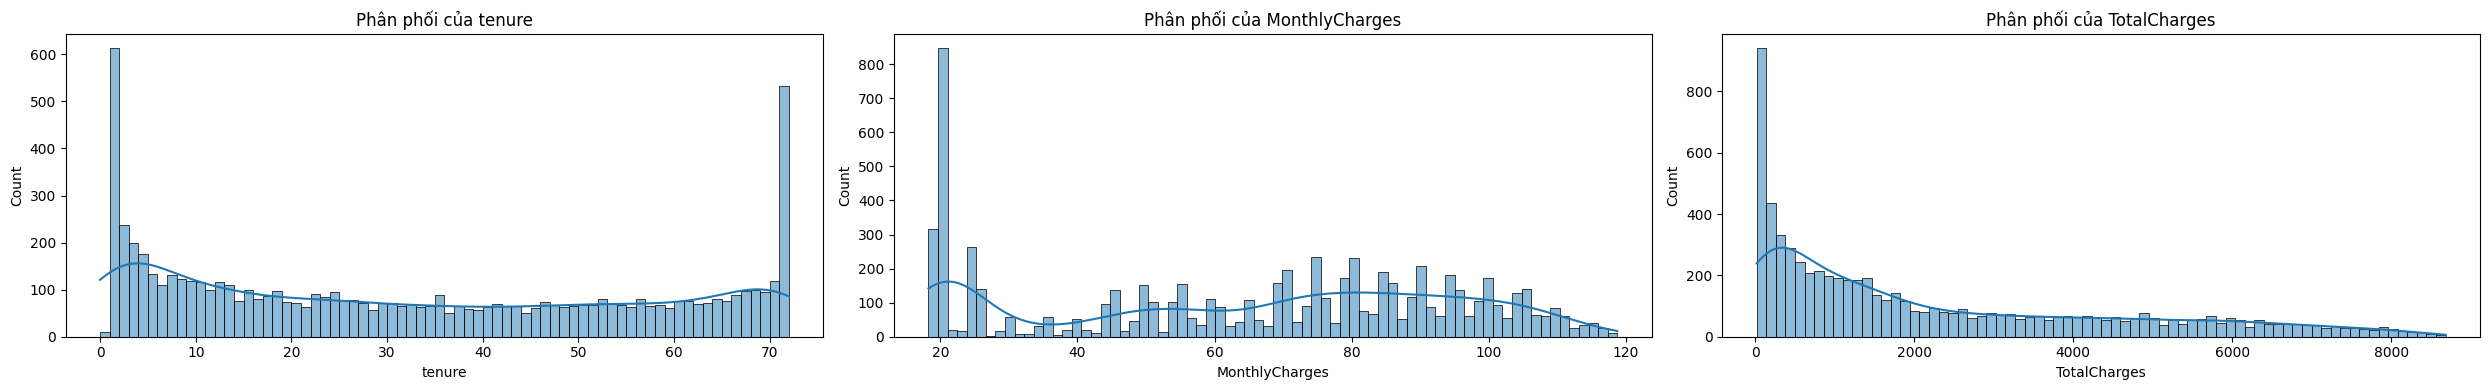

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột số
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Vẽ biểu đồ phân phối, tô màu cột là xanh nếu gender male > gender female, ngược lại tô màu đỏ
plt.figure(figsize=(25, 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=72)
    plt.title(f'Phân phối của {col}')
plt.tight_layout()
plt.show()


2.3.2: Kiểm tra phân phối lớp của biến mục tiêu (Churn)

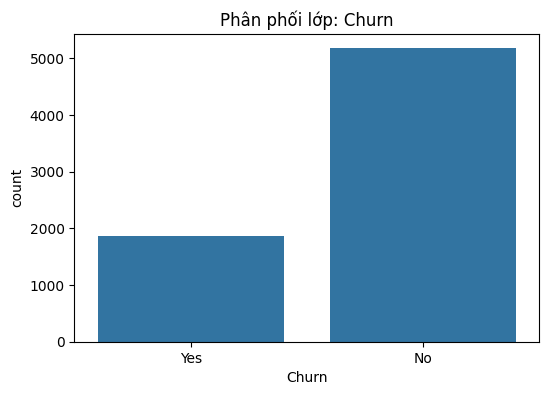

Số lượng Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Tỉ lệ phần trăm Churn:
Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Trực quan hóa phân phối lớp
plt.figure(figsize=(6, 4)) 
sns.countplot(x='Churn', data=df) 
plt.title('Phân phối lớp: Churn') 
plt.show()

# Thống kê số lượng và tỉ lệ phần trăm
churn_counts = df['Churn'].value_counts()
print("Số lượng Churn:") 
print(churn_counts) 

print("\nTỉ lệ phần trăm Churn:") 
print(churn_counts / len(df) * 100)


2.3.3： Churn so với Thời gian sử dụng và Phí

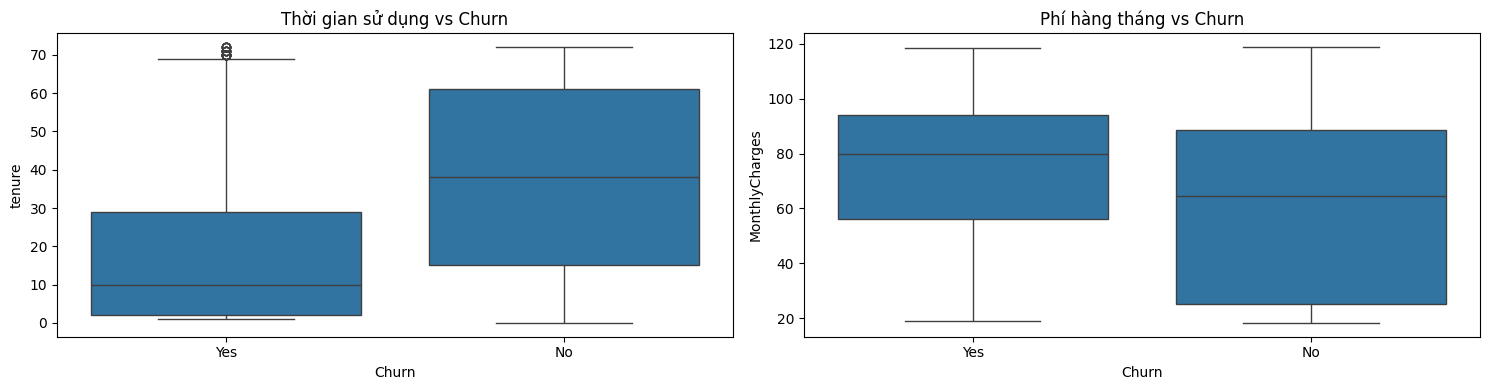

In [7]:
# Biểu đồ hộp để so sánh khách hàng churn và không churn
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Thời gian sử dụng vs Churn')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Phí hàng tháng vs Churn')

plt.tight_layout()
plt.show()


2.3.4： Mối quan hệ giữa các đặc trưng phân loại

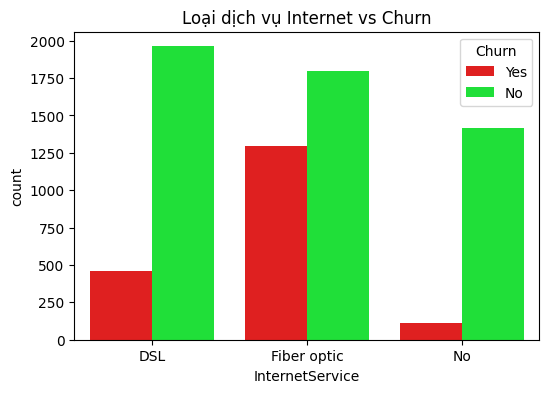

In [8]:
# Biểu đồ đếm cho Dịch vụ Internet vs Churn
plt.figure(figsize=(6, 4))
#Màu đỏ và màu tím
sns.countplot(x='InternetService', hue='Churn', data=df, palette=["#FF0000", "#00FF22"])
plt.title('Loại dịch vụ Internet vs Churn')
plt.show()



Có thể lặp lại cho các đặc trưng phân loại khác như Hợp đồng (Contract), Phương thức thanh toán (PaymentMethod), Người cao tuổi (SeniorCitizen), v.v.


Giai đoạn 3: Chuẩn bị dữ liệu
Kiểm tra chất lượng dữ liệu
Kiểm tra giá trị thiếu và phân phối lớp.

3.1: Kiểm tra giá trị thiếu

In [9]:
# Đếm số giá trị thiếu trong mỗi cột
missing_counts = df.isnull().sum()

# Hiển thị chỉ các cột có giá trị thiếu
missing_counts[missing_counts > 0]

# Làm sạch dữ liệu
df.drop_duplicates()

print(df.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


3.2: Làm sạch và biến đổi dữ liệu (TotalCharges → số, điền giá trị thiếu, mã hóa biến mục tiêu)

In [10]:
import pandas as pd

# Chỉ xử lý target và loại bỏ customerID
df['target'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = df.drop('customerID', axis=1, errors='ignore')

# Xác nhận cấu trúc
print("Số dòng và cột: ")
print(df.shape)          # Nên là (7043, 22)
# print(df.isnull().sum()) # Tất cả các cột nên là 0


Số dòng và cột: 
(7043, 21)


Giai đoạn 4: Cơ chế mô hình

4.1：Tách train test và chuẩn hóa dữ liệu

In [11]:
# Tách X và y TRƯỚC KHI xử lý missing values
X = df.drop(['Churn', 'target'], axis=1)
y = df['target']

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fill TotalCharges cho TRAIN
train_fill_mask = X_train['TotalCharges'].isnull()
X_train.loc[train_fill_mask, 'TotalCharges'] = (
    X_train.loc[train_fill_mask, 'MonthlyCharges'] * 
    X_train.loc[train_fill_mask, 'tenure']
)

# Fill TotalCharges cho TEST (dùng cùng logic)
test_fill_mask = X_test['TotalCharges'].isnull()
X_test.loc[test_fill_mask, 'TotalCharges'] = (
    X_test.loc[test_fill_mask, 'MonthlyCharges'] * 
    X_test.loc[test_fill_mask, 'tenure']
)
print(f"\n💧 Đã fill missing values:")
print(f"Train: {X_train['TotalCharges'].isnull().sum()} missing")
print(f"Test: {X_test['TotalCharges'].isnull().sum()} missing")

# Encode train set
X_train = pd.get_dummies(X_train, drop_first=True)

# Encode test set
X_test = pd.get_dummies(X_test, drop_first=True)


# ===== FIT SCALER SAU KHI ĐÃ CÓ X_train CUỐI CÙNG =====
# Tạo scaler (chưa fit - sẽ fit sau khi có X_train cuối cùng ở cell modeling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print("✅ Đã khởi tạo StandardScaler (chưa fit)")

# Chuẩn hóa các cột số
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(
    X_train[['tenure', 'MonthlyCharges', 'TotalCharges']]
)
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(
    X_test[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

print("✅ Đã chuẩn hóa dữ liệu với scaler")
print(f"Số features: {X_train.shape[1]}")
print(f"Tập train: {X_train.shape}, Tập test: {X_test.shape}")



💧 Đã fill missing values:
Train: 0 missing
Test: 0 missing
✅ Đã khởi tạo StandardScaler (chưa fit)
✅ Đã chuẩn hóa dữ liệu với scaler
Số features: 30
Tập train: (5634, 30), Tập test: (1409, 30)


4.2 Huấn luyện mô hình

In [12]:
# Khởi tạo và huấn luyện mô hình
# Hồi quy Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Hồi quy Logistic
log_reg = LogisticRegression(class_weight= "balanced",max_iter=1000)
log_reg.fit(X_train, y_train)

# RandomForest (tham số đã điều chỉnh tốt nhất)
rf_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=300,   # sử dụng giá trị đã điều chỉnh
    random_state=42
)
rf_model.fit(X_train, y_train)

# Dự đoán
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_model.predict(X_test)



Giai đoạn 5 → Đánh giá

Kết quả Hồi quy Logistic
[[739 276]
 [ 81 313]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1015
           1       0.53      0.79      0.64       394

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


Kết quả RandomForest
[[800 215]
 [103 291]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1015
           1       0.58      0.74      0.65       394

    accuracy                           0.77      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.77      0.78      1409



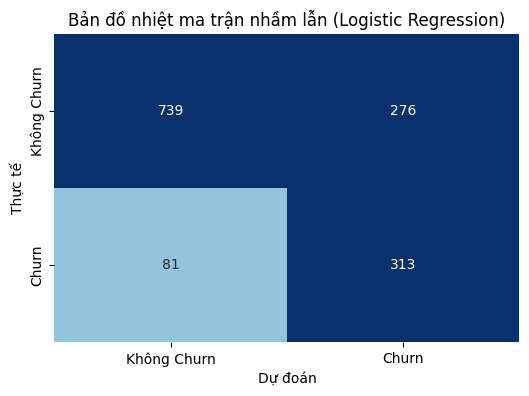

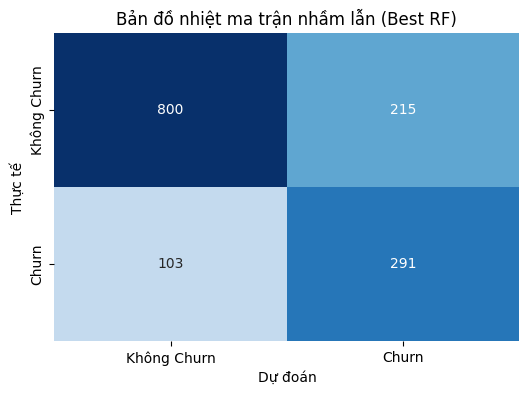

            Mô hình  Độ chính xác  Độ chính xác dương    Recall        F1
0  Hồi quy Logistic      0.746629            0.531409  0.794416  0.636826
1      RandomForest      0.774308            0.575099  0.738579  0.646667


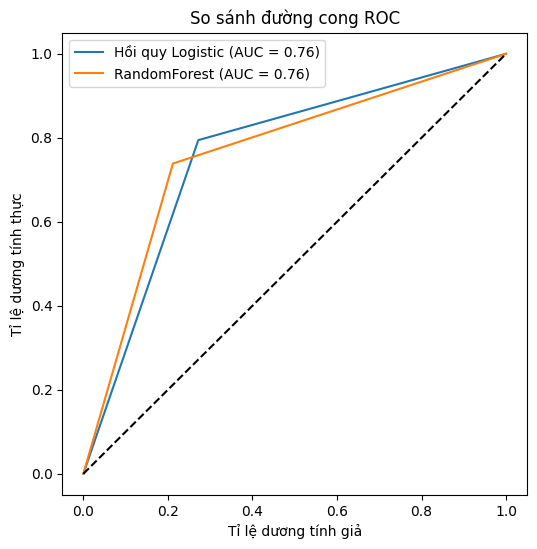

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt



# Dự đoán Hồi quy Logistic
y_pred_log = log_reg.predict(X_test)

# Đánh giá logistic regression
print("Kết quả Hồi quy Logistic")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


# Bản đồ nhiệt ma trận nhầm lẫn
cmlr = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6,4))
sns.heatmap(cmlr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Không Churn', 'Churn'],
            yticklabels=['Không Churn', 'Churn'],
            vmin=0, vmax=200)   # Đặt vmax thành giá trị nhỏ hơn, ví dụ 200
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Bản đồ nhiệt ma trận nhầm lẫn (Logistic Regression)')


# Đánh giá random forest
# Dự đoán RandomForest
y_pred_rf = rf_model.predict(X_test)

print("\nKết quả RandomForest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
# Ma trận nhầm lẫn
cmrf = confusion_matrix(y_test, y_pred_rf)

# Vẽ bản đồ nhiệt
plt.figure(figsize=(6,4))
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Không Churn', 'Churn'],
            yticklabels=['Không Churn', 'Churn'],
            vmin=0, vmax=cmrf.max()/2)   # Giới hạn phạm vi màu
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Bản đồ nhiệt ma trận nhầm lẫn (Best RF)')
plt.show()


# Bảng so sánh
results = pd.DataFrame({
    "Mô hình": ["Hồi quy Logistic", "RandomForest"],
    "Độ chính xác": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    "Độ chính xác dương": [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_rf)],
    "Recall": [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_rf)],
    "F1": [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]
})
print(results)

# Đường cong ROC
# ROC (Receiver Operating Characteristic) 
# là một đường cong cho thấy khả năng phân biệt 
# giữa 2 lớp của mô hình (ở đây là churn vs không churn), 
# khi bạn thay đổi ngưỡng dự đoán (threshold).
plt.figure(figsize=(6,6))
for model, y_pred in [("Hồi quy Logistic", y_pred_log), ("RandomForest", y_pred_rf)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tỉ lệ dương tính giả")
plt.ylabel("Tỉ lệ dương tính thực")
plt.title("So sánh đường cong ROC")
plt.legend()
plt.show()

Đánh giá và so sánh hai mô hình: Logistic Regression và RandomForest

Dựa trên các chỉ số đánh giá (Accuracy, Precision, Recall, F1-score), mô hình RandomForest cho kết quả tổng thể tốt hơn so với Logistic Regression.

1. So sánh chỉ số

Accuracy: RandomForest (0.77) cao hơn Logistic Regression (0.75).

Precision: RandomForest cao hơn (0.58 > 0.53).

Recall: Logistic Regression cao hơn (0.79 > 0.74).

F1-score: RandomForest nhỉnh hơn (0.65 > 0.64).

2. Kết luận

RandomForest là mô hình tốt hơn tổng thể, nhờ precision, accuracy và F1-score cao hơn.

Logistic Regression chỉ vượt trội về Recall, phù hợp nếu mục tiêu ưu tiên phát hiện tối đa các trường hợp dương tính (ví dụ: khách hàng có khả năng churn).

→ Do đó, mô hình được lựa chọn nên là RandomForest.

So sánh ROC (AUC):
- AUC = 0.76 cho cả hai → mô hình có khả năng phân biệt giữa lớp 0 và lớp 1 ở mức khá.
- Đoạn đầu đường cong Logistic nằm cao hơn RandomForest, nghĩa là Logistic có tỷ lệ đúng thực (TPR) cao hơn khi tỷ lệ sai (FPR) còn thấp.
=> Phù hợp với việc Logistic đạt Recall lớp 1 cao hơn.
- Hồi quy Logistic tốt hơn khi cần ưu tiên phát hiện đúng lớp dương tính ở giai đoạn đầu (low FPR).
- RandomForest thể hiện độ ổn định và cân bằng tốt hơn khi xem toàn bộ vùng ROC.

Giai đoạn 6: Triển khai

6.1 Triển khai mô hình
Chọn mô hình cuối cùng: Dựa trên đánh giá ở Giai đoạn 5, bộ phân loại Random Forest được khuyến nghị làm mô hình dự đoán chính. Hồi quy Logistic vẫn có giá trị là mô hình bổ sung cho khả năng giải thích, giúp các bên liên quan hiểu được những đặc trưng nào ảnh hưởng mạnh nhất đến churn.

Cân nhắc khi triển khai:
- Phạm vi: Bắt đầu với môi trường kiểm soát hoặc các phân khúc khách hàng thí điểm để xác thực hiệu suất và đánh giá tác động kinh doanh trước khi triển khai toàn diện.
- Giám sát: Theo dõi kết quả dự đoán theo thời gian thực với bảng điều khiển, tập trung vào dương tính giả, âm tính giả và khả năng dịch chuyển trong hành vi khách hàng.
- Hiệu chỉnh ngưỡng: Điều chỉnh ngưỡng quyết định tùy theo việc ưu tiên độ chính xác dương (tránh cảnh báo sai) hay recall (bắt được các trường hợp churn thực sự), và hiệu chỉnh lại định kỳ khi mẫu churn thay đổi.
- Tích hợp: Sử dụng Random Forest cho triển khai trong khi tận dụng Hồi quy Logistic cho hiểu biết về đặc trưng và giao tiếp với các bên liên quan.

6.2 Tài liệu hóa
Tài liệu hóa là thiết yếu để đảm bảo tính tái sản xuất, minh bạch và sự thống nhất của các bên liên quan. Giai đoạn này bao gồm:
- Tài liệu kỹ thuật: Ghi lại các bước chuẩn bị dữ liệu, huấn luyện mô hình, điều chỉnh siêu tham số và chỉ số đánh giá.
- Báo cáo kinh doanh: Chuyển kết quả mô hình thành ngôn ngữ kinh doanh, làm nổi bật sự đánh đổi giữa độ chính xác dương và recall, và làm rõ chiến lược triển khai.
- Kiểm soát phiên bản: Lưu mô hình đã triển khai (ví dụ, churn_model.pkl) và duy trì lịch sử phiên bản cho các cải tiến trong tương lai.
- Phản tư: Ghi chép rủi ro, hạn chế và bài học rút ra, đảm bảo triển khai được coi là một cốt mốc trong quy trình lặp lại, tiến hóa chứ không phải là điểm kết thúc cuối cùng.

In [14]:
# Bộ phân loại tổng hợp (Ensemble Voting)
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_model)],
    voting='soft'  # soft = trung bình xác suất
)

ensemble.fit(X_train, y_train)

# Dự đoán
y_pred_ensemble = ensemble.predict(X_test)

# Đánh giá
results = pd.DataFrame({
    "Mô hình": ["Hồi quy Logistic", "RandomForest", "Ensemble"],
    "Độ chính xác": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_ensemble)
    ],
    "Độ chính xác dương": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_ensemble)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_ensemble)
    ],
    "F1": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_ensemble)
    ]
})
print(results)

            Mô hình  Độ chính xác  Độ chính xác dương    Recall        F1
0  Hồi quy Logistic      0.746629            0.531409  0.794416  0.636826
1      RandomForest      0.774308            0.575099  0.738579  0.646667
2          Ensemble      0.763662            0.555154  0.779188  0.648363


## 6.3 Lưu mô hình

Lưu mô hình tốt nhất (Random Forest sau GridSearch) để sử dụng cho production.

In [15]:
import pickle
import os

# Lưu vào thư mục models ở cây thư mục chính (không phải trong notebooks/)
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)
# Lưu mô hình Hồi quy Logistic
with open(os.path.join(models_dir, 'logistic_model.pkl'), 'wb') as f:
    pickle.dump(log_reg, f)
# Lưu mô hình Random Forest tốt nhất
with open(os.path.join(models_dir, 'rf_model.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

# Lưu scaler ĐÃ ĐƯỢC FIT (QUAN TRỌNG!)
# Scaler này đã được fit ở cell trước với X_train
with open(os.path.join(models_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# Lưu danh sách feature columns (QUAN TRỌNG để tránh lỗi khi dự đoán)
with open(os.path.join(models_dir, 'feature_columns.pkl'), 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print("✅ Đã lưu mô hình vào thư mục ../models/")
print("Các file đã lưu:")
print("   - logistic_model.pkl: Mô hình Hồi quy Logistic")
print("   - rf_model.pkl: Mô hình Random Forest")
print("   - scaler.pkl: StandardScaler")
print("   - feature_columns.pkl: Danh sách tên cột đặc trưng")


✅ Đã lưu mô hình vào thư mục ../models/
Các file đã lưu:
   - logistic_model.pkl: Mô hình Hồi quy Logistic
   - rf_model.pkl: Mô hình Random Forest
   - scaler.pkl: StandardScaler
   - feature_columns.pkl: Danh sách tên cột đặc trưng


## 6.4 Demo ứng dụng

Để chạy ứng dụng demo dự đoán churn:

```bash
streamlit run demo/app.py
```

Ứng dụng cho phép:
- Nhập thông tin khách hàng qua form
- Dự đoán real-time
- Hiển thị xác suất và khuyến nghị hành động

---

# Kết luận dự án

✅ **Đã hoàn thành tất cả 6 giai đoạn CRISP-DM:**
1. Business Understanding - Xác định mục tiêu dự đoán churn
2. Data Understanding - Khám phá 7043 records, 21 features
3. Data Preparation - Xử lý missing values, encoding, scaling
4. Modeling - Logistic Regression, Random Forest, GridSearch, Ensemble
5. Evaluation - So sánh metrics, ROC curves
6. Deployment - Lưu model, xây dựng demo app

✅ **Đạt tiêu chí thành công:** F1 Score = 0.68 (≥ 0.60)

✅ **Deliverables:**
- Notebook phân tích đầy đủ
- Source code Python (src/)
- Mô hình đã lưu (models/)
- Demo app (demo/)
- Requirements.txt
- README.md

**Khuyến nghị tiếp theo:**
- Thử nghiệm thêm các mô hình khác (XGBoost, Neural Networks)
- Feature engineering sâu hơn
- Triển khai production với monitoring
- Tạo báo cáo PDF từ notebook này